In [1]:
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import time as t

In [2]:
import pandas as pd
import sys
from env_pybullet_gen3 import env_pybullet_kin_gen3



In [3]:
#To improve the velocity, run it on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device ', device)



#Create a experiment env
env = env_pybullet_kin_gen3(no_zeros = True)
env.robot.visual_inspection = False

#Initially parameters of the urdf



print('observation space:', env.observation_space) #states, There is only 1 state constant
env.update_parameters_to_modify(["mass","max_vel","kp","ki","damping","force_x_one","Ixx","Iyy","Izz"])
print('action space:', env.action_space) #parameters, number of parameters choose to tune, continuous
print('original action:', env.action_original()) #parameters, number of parameters choose to tune, continuous




Device  cpu
hola
../Simulation_Pybullet/models/urdf/JACO3_URDF_V11.urdf
Robot launched
hola
(7, 12)
(7, 17)
observation space: 1
mass okey
max_vel okey
kp okey
ki okey
damping okey
force_x_one okey
Ixx okey
Iyy okey
Izz okey
action space: 63
original action: [1.377353, 1.163667, 1.16366, 0.930287, 0.678106, 0.678106, 0.500657, 30, 30, 30, 30, 30, 30, 30, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1, 1, 1, 1, 0.00480078220558528, 0.008418724123621643, 0.007544516197001279, 0.0064096919604697605, 0.0016797846804208455, 0.0019375935324615593, 0.0007750385804833523, 0.004755191268457921, 0.0019202057294098781, 0.007486605057526543, 0.0013804130332615912, 0.0015062421641084327, 0.0008273237988932355, 0.0005849825981943527, 0.0022826303695446856, 0.00836116845951151, 0.0019205500000651847, 0.006517816917001926, 0.0008260694053789821, 0.0017630597813546379, 0.0009751695712112207]


In [4]:
#Cross Entrophy Method, to choose the weights

# In my case where only 1 action,and that it's apply the parameters do another step doesn't change anything due to the state doesn't vary
# For this reason max_t and gama doesn't make sense, so I set them to max_t = 1 and gamma to 0
def cem_no_net(n_iterations=600, max_t=1, gamma=0.0, print_every=100, pop_size=env.action_space, elite_frac=0.1, sigma=0.05,sigma_reduction_every_print = 0.65, per_one = True ):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
        per_one (boolean): to determine if the output is in per one or not
    """
    #Numbers of elements that you keep as the better ones
    n_elite=int(pop_size*elite_frac)
    
    #scores doble end queee , from iterations size * 0.1
    scores_deque = deque(maxlen=int(n_iterations*0.1))
    #intial scores empty
    scores = []
    #Select a seed to make the results the same every test, not depending on the seed
    np.random.seed(0)
    #Initial best weights, are from 0 to 1, it's good to be small the weights, but they should be different from 0.
    # small to avoid overfiting , different from 0 to update them
    
    if (per_one == True):
        best_weight = sigma*np.random.randn(env.action_space)
        original_action = np.array(env.action_original())
    else:
        best_weight = np.add(sigma*np.random.randn(env.action_space),env.action_original())

    #Each iteration, modify  + (from 0 to 1) the best weight randomly
    #Computes the reward with these weights
    #Sort the reward to get the best ones
    # Save the best weights
    # the Best weight it's the mean of the best one
    #compute the main reward of the main best rewards ones
    #this it's show to evalute how good its
    
    for i_iteration in range(1, n_iterations+1):
        
        #Generate new population weights, as a mutation of the best weight to test them
        weights_pop = [best_weight + (sigma*np.random.randn(env.action_space)) for i in range(pop_size)]
        
        #Compute the parameters and obtain the rewards for each of them
        
        if (per_one == True):
            rewards=[]
            for weights in weights_pop:
                #print(weights)
                action=np.add(np.multiply(weights,original_action),original_action)
                #t.sleep(10)
                rewards.append( env.step_tcp(action) )
            rewards = np.array(rewards)
        else:
            rewards=[]
            for weights in weights_pop:
                rewards.append(env.step_tcp(weights) )
            rewards = np.array(rewards)
        print("rewards" + str(i_iteration))
        print(rewards)
        #print("\n")
        
        #Sort the rewards to obtain the best ones
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        
        #Set the best weight as the mean of the best ones 
       
        best_weight = np.array(elite_weights).mean(axis=0)
        
        #Get the reward with this new weight
        if (per_one == True):
            action = np.add(np.multiply(best_weight,original_action),original_action)
            reward = env.step_tcp(action)
        else:
            reward = env.step_tcp(best_weight)
        scores_deque.append(reward)
        scores.append(reward)
        
        #save the check point
        env.save_parameters("./Parameters_train_tcp_2.xlsx")
        
        if i_iteration % print_every == 0:
            sigma = sigma * sigma_reduction_every_print
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=0.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-n_iterations*0.1, np.mean(scores_deque)))
            break
    return scores


rewards1
[-64.02979128 -53.87525369 -51.97947055 -60.77164972 -58.13343155
 -51.78795133 -54.4347823  -59.30864051 -62.33167072 -56.68958086
 -52.54439308 -57.67421337 -60.03190428 -54.43839935 -56.37030546
 -56.43995164 -58.9135443  -56.06076261 -61.17937854 -67.19455113
 -56.68378265 -54.77744418 -62.14114409 -57.41946263 -53.85676661
 -55.60662132 -59.74013673 -55.83867146 -58.9655     -58.37001874
 -50.4837704  -56.22370363 -64.81597914 -66.09987079 -66.78030831
 -55.29895356 -55.92308848 -56.15829773 -55.19457958 -58.09764758
 -63.9202166  -52.43963835 -54.54814206 -53.38344892 -51.94037343
 -62.73489068 -59.61483619 -53.26671545 -59.56210063 -53.11429546
 -62.7895228  -62.01019    -52.18300677 -52.9488757  -57.20104623
 -52.82951893 -57.81983522 -58.8584109  -56.05815809 -60.98154993
 -68.34832467 -56.08259227 -53.20304377]
rewards2
[-50.30974222 -53.86239015 -51.43563571 -50.17817077 -48.37811356
 -49.06053092 -48.60052282 -53.26739063 -50.07050641 -51.64286217
 -54.67291204 -53

rewards11
[-39.51752109 -43.71630357 -39.91238044 -39.84413681 -39.37529029
 -39.25654489 -39.71678143 -40.41281439 -39.05535412 -37.2736837
 -37.99250819 -41.82906755 -40.97837196 -39.11230168 -38.97626381
 -37.49680331 -37.83874964 -38.15485003 -40.2060157  -41.10883797
 -38.28151737 -40.66590883 -39.20250211 -39.91587674 -39.02474395
 -40.08812015 -39.63368843 -38.76336441 -41.81491513 -37.93768559
 -37.84683593 -39.83075423 -41.19268111 -41.57760393 -39.00058127
 -40.59011146 -39.51487081 -39.74127841 -40.4710575  -39.84010745
 -38.79101615 -40.45943215 -41.27371053 -39.09938093 -37.57343087
 -39.87970752 -40.95922677 -43.83895347 -39.42501418 -46.05630426
 -38.4412427  -41.51529872 -40.17472463 -40.43447933 -40.38607514
 -40.31816063 -41.05786647 -38.84829487 -39.68011572 -41.82657943
 -38.93362707 -40.47436053 -39.30542133]
rewards12
[-36.47737776 -38.9402853  -38.42093219 -39.01899452 -40.10689317
 -40.41443626 -40.52677898 -39.14553255 -39.46596891 -40.30557039
 -38.67270193 -3

rewards21
[-26.39276817 -25.08304484 -24.43340253 -24.21337105 -23.53181499
 -26.03392372 -27.43146501 -26.8192965  -24.65255872 -25.17494573
 -25.35406994 -24.09830791 -24.83340306 -26.72227807 -24.09812222
 -28.27484156 -26.30211653 -26.30116361 -23.21602546 -26.50313809
 -29.38880012 -30.08047988 -24.18538571 -27.49958718 -24.08336738
 -25.87492742 -24.73795868 -27.56212776 -26.91005246 -26.78891026
 -26.08015978 -23.80457678 -27.04613961 -27.1398906  -30.78773337
 -23.86348996 -28.85062243 -25.21900551 -23.73999741 -24.44745864
 -26.31234197 -24.60451404 -24.4263665  -24.24953468 -26.76679091
 -27.65909978 -24.79415246 -24.91030042 -27.60799151 -24.70370223
 -26.89337699 -27.64514445 -24.9265174  -26.0694378  -28.21211967
 -26.33806292 -25.0969249  -26.53238223 -28.19500991 -27.77204444
 -24.94138273 -23.31875798 -23.56156608]
rewards22
[-23.18276333 -23.45354405 -24.33008662 -23.0075619  -27.61297109
 -25.04085742 -28.59272275 -30.93641095 -25.62715269 -25.66010734
 -24.89401701 -

rewards31
[-23.62566593 -25.26389291 -23.39735477 -23.49233086 -25.72176584
 -22.12749041 -21.7809637  -25.6464654  -22.20904811 -24.95381937
 -24.69211406 -25.57362457 -22.57239712 -26.60452703 -25.26911172
 -22.52014226 -24.84734707 -21.90907504 -22.69592922 -22.50853822
 -26.67897126 -27.02008109 -24.13364285 -25.76521861 -21.93287844
 -24.11804752 -24.58547659 -26.06295949 -22.46679547 -25.11238617
 -25.80859982 -22.58841292 -25.7070328  -24.4326669  -22.76105399
 -25.12429078 -24.72544024 -23.15385386 -23.60979845 -25.53734873
 -25.92521653 -23.29746054 -25.53430045 -23.75080471 -26.4880809
 -22.92567124 -26.7559759  -28.19686816 -24.52781867 -22.73670409
 -22.05133538 -22.2047987  -22.56573852 -25.19736006 -23.96652997
 -26.49574661 -24.91343725 -23.82227202 -22.65506858 -21.58632819
 -22.78230194 -21.69678432 -25.67241102]
rewards32
[-22.20384042 -26.92556207 -25.05896909 -27.84257466 -21.46963875
 -25.59304415 -24.2471097  -26.45517802 -22.96512356 -23.0958607
 -21.01781992 -24

rewards41
[-24.3452658  -25.50657571 -22.5961683  -21.88641757 -22.90655645
 -22.06952203 -20.92876301 -22.91201047 -23.19015468 -22.37649536
 -23.27221561 -23.2387132  -24.98831443 -22.68862561 -23.96576301
 -22.96289205 -25.13656435 -22.94028547 -23.5047199  -22.08355484
 -25.72448909 -22.32970072 -26.30083563 -24.43633246 -23.26263722
 -21.93120865 -22.99272176 -25.13717325 -24.34086392 -22.79135422
 -27.43516122 -23.24317995 -25.90069811 -28.81653851 -22.63643343
 -21.77970312 -22.91791634 -25.20168981 -24.01469087 -23.89812952
 -22.79942466 -21.61607467 -22.88599625 -20.99314561 -21.342686
 -22.65535749 -25.1566707  -21.59382133 -24.14889021 -23.16401395
 -25.30213253 -22.79572317 -23.38557164 -25.15322691 -28.37119744
 -22.33702762 -26.58491627 -24.20535964 -23.16913213 -22.74418834
 -26.02263531 -22.58379416 -24.49253266]
rewards42
[-23.29758986 -21.64738081 -21.8098095  -23.55753696 -21.46765841
 -22.63824453 -23.88023852 -23.66205456 -22.50271005 -23.05259396
 -22.46526013 -28

rewards51
[-23.10260118 -24.94747313 -22.45033793 -24.18391481 -21.93044457
 -21.18254551 -21.21734089 -22.83143303 -22.98258433 -22.64400093
 -22.83093347 -22.50541073 -23.44174439 -24.20659811 -22.12355486
 -22.29779094 -21.83069189 -24.81742224 -24.55357037 -21.7646465
 -21.24376683 -21.38585145 -23.3368451  -21.84171016 -23.75758281
 -22.87608407 -22.0301199  -21.83021863 -21.90457482 -21.85132759
 -22.4926598  -20.41204364 -25.36239106 -21.17272304 -21.95010997
 -22.46343469 -25.35318682 -22.70728657 -24.38514323 -27.24511555
 -22.15324012 -22.01892248 -21.95973343 -22.99624843 -22.16860452
 -22.01680865 -21.88198795 -20.4081098  -23.19253907 -23.53606998
 -24.2093922  -22.43123666 -22.02843816 -25.03037754 -26.38121341
 -24.44656759 -21.27337705 -21.9538163  -25.10420919 -22.959959
 -23.24445976 -22.98704362 -22.23293589]
rewards52
[-25.68299208 -21.64821815 -23.2407866  -23.65222266 -22.60256561
 -22.89877244 -21.13795613 -22.05272658 -24.11384371 -25.22944183
 -23.53379014 -27.

rewards61
[-22.02814144 -22.06852104 -23.76677937 -22.75855393 -29.13264984
 -23.0095266  -21.73923134 -23.31813166 -22.11998741 -21.14858944
 -22.82037157 -21.28562403 -26.88363256 -22.56006663 -21.46461359
 -22.18399458 -21.79833683 -22.30190273 -22.80337609 -25.15707933
 -21.16934257 -23.85296883 -23.3523958  -22.22460583 -22.34165054
 -22.35475486 -21.638768   -24.00528791 -20.31584646 -21.03546266
 -21.9084491  -22.79835136 -24.2283949  -23.85180956 -21.98335487
 -21.18596841 -25.04216303 -21.6961445  -23.44266608 -26.05242634
 -22.22015548 -21.37760392 -24.09429127 -24.1752014  -23.80814979
 -21.95178702 -22.45716834 -20.77114354 -24.69780878 -23.55132903
 -22.07526771 -22.43738297 -21.67101466 -23.16602981 -27.66178927
 -23.25232701 -23.34241951 -21.85376941 -23.04971595 -21.54490611
 -22.2663839  -20.87542012 -23.38128132]
rewards62
[-23.63058781 -24.33534538 -25.39170255 -22.54745892 -20.7690379
 -20.55892625 -21.88272669 -21.43983652 -25.71036057 -26.71873207
 -20.87102423 -2

rewards71
[-25.37669938 -21.26936273 -23.21494361 -24.73174762 -22.80191807
 -20.21271769 -20.72049114 -21.99712142 -23.49219807 -20.70439825
 -24.45428149 -21.25530669 -22.53922029 -23.75450735 -23.03979223
 -24.66178219 -20.69384113 -22.14035072 -20.9365942  -22.97179762
 -22.2845786  -19.83592106 -20.59230102 -20.91192878 -22.27011791
 -22.85990128 -21.02794341 -24.43047008 -23.5017808  -21.3217243
 -24.88742481 -20.57414299 -22.00142826 -22.32076348 -22.09287764
 -20.89429073 -19.6191968  -21.74689914 -20.82623184 -19.44467395
 -21.41527395 -20.51084677 -21.81242886 -20.84879337 -23.37423554
 -20.2868994  -22.46110347 -19.64536604 -20.970982   -21.26889161
 -24.89860695 -22.19122895 -24.35476987 -22.30660808 -31.01905511
 -21.78575719 -20.68231053 -27.62147855 -23.80499832 -21.39314024
 -24.29471162 -21.60243349 -22.94095991]
rewards72
[-21.87504035 -22.29003227 -21.21394621 -24.76349595 -18.69848927
 -21.05610855 -23.27431644 -25.52267416 -23.23345028 -22.401423
 -19.92237983 -21.

rewards81
[-22.74859465 -22.48054362 -20.87980074 -22.33661088 -21.27719834
 -21.42894922 -20.19515346 -19.92025362 -21.05861289 -22.0449199
 -20.98581918 -22.04832528 -23.53344165 -20.83056512 -21.23210006
 -21.73381577 -19.24730008 -23.80874972 -20.6868065  -23.64438615
 -23.94616001 -21.31237006 -21.3286096  -19.83975297 -20.22707205
 -21.16903013 -21.97785406 -20.85555943 -21.47769616 -20.71688797
 -20.05090327 -21.64816992 -21.35348749 -19.88403087 -21.1900263
 -24.13925474 -20.61293786 -20.37612781 -21.89498693 -22.95953164
 -23.9594603  -20.94199358 -19.45285568 -21.17879477 -19.26288397
 -20.38703623 -19.86003082 -22.40173936 -21.51415739 -25.0710498
 -24.94467712 -20.53143868 -19.80774519 -22.18903245 -24.56476019
 -22.55754823 -23.16617775 -21.06552517 -22.68667443 -22.04587482
 -23.63330624 -20.01864913 -21.46869043]
rewards82
[-19.66940556 -21.00446896 -22.3133214  -19.30367557 -22.34383704
 -20.12587004 -21.42498215 -22.46556604 -22.58837441 -25.52339556
 -20.29924911 -19.

rewards91
[-23.48886578 -20.37251102 -24.42278356 -19.66361009 -21.1991611
 -21.06273576 -23.19098561 -22.53571638 -21.89883521 -22.38790519
 -21.19270997 -19.78849394 -21.80499597 -19.61397182 -21.37181446
 -21.31511984 -20.81320739 -19.428791   -20.79039216 -24.21553746
 -21.99150844 -21.34356768 -20.11511918 -21.37748499 -18.82898957
 -20.92835328 -21.56291535 -21.91867071 -20.62459354 -22.66098868
 -20.55918345 -21.30235315 -19.67766898 -20.45181381 -22.72751398
 -32.53142621 -19.16553604 -20.74697593 -19.95964662 -20.91849659
 -23.67487564 -21.25607841 -22.03934348 -21.46575799 -21.29721014
 -20.42267421 -19.41981901 -18.74130095 -22.77101807 -20.70009451
 -20.12535082 -19.45915692 -20.21518629 -19.94154099 -21.61256505
 -19.31401177 -19.3058876  -22.19552169 -23.25355244 -18.9707927
 -20.54504682 -20.5455176  -21.10215985]
rewards92
[-22.38162646 -22.47380041 -21.10983363 -22.28987697 -26.06563407
 -22.60385987 -20.56268217 -18.32566728 -21.59158252 -20.04959645
 -20.33860245 -20

rewards101
[-19.3654927  -24.19736598 -19.92307103 -18.15834411 -19.51636889
 -18.53732376 -19.82941449 -18.75193577 -19.09415144 -19.76258427
 -19.80109917 -18.32579803 -19.02725714 -20.54701003 -18.69386342
 -18.97856997 -18.90729504 -18.58107968 -19.60409746 -18.98644769
 -19.77148447 -19.71483714 -19.82490941 -19.37098012 -20.30685885
 -20.36993839 -19.88699025 -20.4265847  -18.96201142 -19.75258466
 -19.61929369 -20.69277222 -19.65419824 -20.98009062 -19.84047048
 -19.54716095 -19.04546669 -19.1470946  -20.35047529 -20.10683078
 -19.89272035 -19.5850843  -20.05218986 -21.23852089 -18.84438049
 -20.58273815 -19.14899998 -20.13445352 -20.1029242  -19.17762403
 -19.14710226 -19.35604362 -20.0063219  -19.25805415 -23.88261267
 -18.76097941 -19.57456517 -19.76497875 -19.24791884 -18.84897932
 -19.32104083 -20.02292931 -19.72245413]
rewards102
[-21.86942976 -20.1432968  -20.67596816 -20.70554043 -19.75244029
 -20.33785324 -19.51154279 -18.74558867 -18.81405701 -20.27110562
 -19.59020229

rewards111
[-18.43993868 -24.09165809 -19.04284405 -20.9885973  -18.37833014
 -18.69453355 -20.13270624 -22.48589779 -19.42876353 -20.3417072
 -19.47059022 -19.5169984  -18.80049668 -20.22189451 -19.62992164
 -20.08471584 -19.9836194  -19.59948326 -19.76146447 -19.44746963
 -19.42213857 -20.15919555 -19.49016388 -19.57119488 -18.9850574
 -19.20151432 -20.22019242 -21.61817541 -20.40440196 -19.59488176
 -17.79781489 -19.21411999 -19.0457719  -20.04322607 -18.46184614
 -19.76069047 -20.07365628 -18.08496557 -18.94866463 -20.24285076
 -19.784005   -18.75050307 -18.30534084 -21.23511246 -20.2750614
 -19.17114807 -19.66955762 -18.23826295 -19.42818017 -20.59342691
 -17.99409691 -20.14302318 -20.24269537 -18.87575068 -18.07137561
 -19.86723186 -19.41402184 -18.22038512 -19.24834738 -18.25913238
 -20.55143144 -19.61139626 -20.09946049]
rewards112
[-19.63571393 -19.93073135 -19.10102964 -19.24577874 -18.08772975
 -20.11055034 -20.04837131 -19.09607883 -18.6688366  -20.95923769
 -19.89409415 -1

rewards121
[-17.58017414 -20.01080868 -19.66400303 -18.15171339 -19.84220966
 -19.64491418 -19.09395857 -19.0649507  -19.01361642 -20.4468618
 -19.81477554 -19.40597973 -17.76082052 -19.68298356 -18.57396517
 -19.70402022 -19.95338578 -17.54131879 -19.87561094 -17.94428718
 -18.4520974  -19.08529513 -21.32944713 -21.56126785 -19.20289849
 -19.5073336  -19.614032   -20.39448801 -19.33610256 -20.13417612
 -18.29640113 -20.36966916 -19.09729391 -18.08497318 -18.87528225
 -19.46465572 -20.00749526 -18.26620787 -18.45051779 -19.74995737
 -18.29532018 -19.55724006 -18.41587864 -17.91067933 -20.7144759
 -19.8236911  -18.80469846 -17.67799852 -20.47466546 -20.53940969
 -21.05899793 -19.13808001 -19.04019582 -17.9636702  -18.05985356
 -19.53028688 -17.96540294 -19.98397502 -21.75206086 -19.56259194
 -20.59185931 -17.83401987 -17.97640625]
rewards122
[-17.47729623 -20.20519911 -19.84009517 -20.05081648 -20.18253265
 -19.43991722 -19.54514378 -22.30166989 -20.10450967 -19.09956134
 -19.84348318 -

rewards131
[-19.97217119 -19.44301091 -19.72154352 -17.7312967  -19.85976064
 -19.36647584 -19.74670077 -18.00862366 -18.98223552 -19.72872755
 -19.41250552 -19.63649563 -19.82833712 -19.44582341 -19.33358371
 -18.8007615  -19.7699572  -19.38966809 -18.16679141 -21.41748712
 -19.5288092  -19.40448834 -18.12493336 -20.20891038 -17.76871629
 -18.11801456 -21.87928874 -19.09420053 -18.53437538 -17.81357449
 -18.99945015 -19.04198554 -22.4574389  -18.69913525 -17.59761937
 -19.22524848 -19.41474048 -19.37935216 -19.1939328  -19.68546979
 -21.31848506 -19.05906456 -18.86119475 -19.57556481 -18.47548396
 -21.39307608 -19.49093345 -18.84322493 -20.02506433 -18.24265053
 -18.22929018 -18.04926272 -18.46532477 -19.58273713 -22.1599203
 -18.95164654 -18.57390168 -17.4157228  -19.1292063  -19.05289367
 -18.78397985 -19.26633082 -19.13932593]
rewards132
[-18.71959006 -19.46879426 -19.93292867 -18.66889024 -20.34116405
 -19.73436563 -18.59887479 -17.64573411 -19.43291413 -19.71496607
 -19.4164105  

rewards141
[-19.66976351 -18.72354578 -18.90934464 -19.98835377 -19.19138074
 -19.49858863 -17.95905698 -18.88767904 -19.62803661 -18.53504029
 -18.89133863 -18.797043   -18.48868537 -21.1202546  -19.15826305
 -20.44886208 -18.76004934 -17.53356339 -18.42553384 -20.33409154
 -20.06271483 -18.93984475 -17.56976029 -18.82127177 -19.29201228
 -18.88526907 -18.27445044 -18.9441037  -18.35769401 -17.94108862
 -18.93051641 -17.80500661 -18.78198539 -17.29584545 -20.72999735
 -20.03447624 -21.431885   -19.34871639 -18.85627443 -18.60667937
 -18.794842   -18.23962887 -18.5650298  -19.26332313 -20.89289924
 -17.39805982 -17.31483729 -19.90770793 -17.72358208 -18.82639234
 -17.77796543 -19.6273337  -19.19197645 -18.23758749 -19.99076357
 -22.71751341 -19.14923694 -19.15172924 -19.3788834  -18.90132066
 -19.56242227 -17.77698072 -18.81903533]
rewards142
[-18.5698026  -19.29872383 -18.74193592 -19.02137214 -18.68128487
 -18.07916684 -21.44778045 -18.44311212 -19.64740222 -19.05287192
 -17.65885253

rewards151
[-18.9576756  -19.62597795 -19.06241191 -17.48906068 -18.36979671
 -17.35800946 -21.29656672 -18.13420736 -20.52809303 -19.18948441
 -18.78983724 -20.32860595 -21.06666323 -18.45153949 -19.01517752
 -17.98652207 -18.82347708 -18.5043233  -17.89032051 -17.84061452
 -20.43661415 -20.77516276 -17.60897831 -20.27463647 -20.15397631
 -18.70683876 -19.18684113 -20.46252847 -18.82495598 -17.52581643
 -19.03836985 -18.78724202 -19.00422155 -19.29878482 -18.13147098
 -17.36324911 -20.4018237  -19.90598098 -18.38308761 -20.36822475
 -19.44041684 -18.31972252 -19.05403399 -17.23308018 -17.58848013
 -19.11054413 -19.65160253 -18.84271823 -17.28972225 -19.68883092
 -18.12419468 -18.66807806 -18.91042649 -19.03610753 -19.73149682
 -20.65858622 -19.12171813 -19.95234623 -18.76700758 -19.17526391
 -19.46510892 -18.87524544 -19.96666424]
rewards152
[-19.811571   -21.0932615  -18.5582705  -19.58054357 -18.07743858
 -20.02622231 -17.95680483 -20.14876616 -19.85108812 -18.72694972
 -18.34365022

rewards161
[-18.79905834 -18.83971423 -18.50725613 -19.77897126 -18.12487831
 -19.17247463 -18.6509     -17.96535537 -20.26295109 -18.17355474
 -19.16038284 -19.51472673 -19.46518498 -17.88739482 -19.79517947
 -18.31037393 -18.76584342 -21.1270974  -18.91291185 -18.82699516
 -17.86612448 -18.81857458 -19.14935849 -18.39312327 -17.51838162
 -19.42559361 -17.76830554 -19.48031275 -20.05529097 -18.45295857
 -20.13274018 -20.16344905 -20.13535264 -18.77773231 -17.74493086
 -18.82214868 -20.32181384 -18.70038929 -19.53047931 -19.6385099
 -20.89709856 -19.79534921 -17.09223461 -17.27336483 -19.22081641
 -17.53332786 -19.09204094 -18.63133509 -17.93200884 -19.44504158
 -18.81035417 -17.30846769 -17.38647367 -18.75932342 -17.72951873
 -18.91993022 -18.51458636 -18.57201851 -18.50676362 -19.93864222
 -19.30708652 -17.96990796 -17.931262  ]
rewards162
[-20.04266285 -18.12762046 -18.87469273 -18.68603651 -19.27937538
 -17.77690711 -20.12840033 -20.06384711 -19.63036286 -19.86564385
 -18.78830523 

rewards171
[-18.14766911 -18.35534206 -16.69146184 -17.53467049 -18.35883419
 -16.65240835 -18.43039723 -17.03244885 -16.7397897  -19.4935513
 -17.11527487 -18.70610543 -16.92095734 -20.69944606 -21.24230509
 -19.22757484 -19.20839639 -19.67711481 -17.53157854 -18.58753505
 -19.05530515 -17.17540686 -18.81855809 -20.22980005 -18.13026298
 -18.83250583 -17.88630332 -18.61592612 -17.23052942 -16.97244069
 -17.01081608 -19.95249923 -18.62260187 -18.94344607 -18.78752769
 -18.11672193 -16.98623986 -18.01015073 -16.97877581 -18.24219331
 -19.6865666  -18.0475869  -20.98388691 -16.95947576 -17.13739973
 -19.10095349 -18.11978082 -16.84301598 -18.93380104 -17.10278834
 -18.83364417 -17.8798274  -17.89310154 -17.4865532  -18.23177728
 -19.04862814 -17.73958599 -18.87122276 -18.3771186  -17.28207231
 -19.01786151 -17.07771287 -17.31539214]
rewards172
[-18.61041849 -17.86003314 -19.24979121 -18.86991101 -17.53382165
 -19.14187521 -16.86393109 -18.25631437 -19.73654199 -18.16523127
 -17.3144052  

rewards181
[-19.20285998 -17.22745651 -18.79586045 -17.87635812 -17.90513474
 -19.46341173 -18.58993876 -18.07268937 -18.14100446 -19.70384635
 -16.91007785 -16.82719573 -17.93003539 -18.00483333 -18.51051159
 -19.6293416  -17.08757922 -17.44731084 -19.16615694 -19.0892038
 -17.24276491 -18.64998473 -18.43254729 -18.12698485 -17.49214528
 -18.41286698 -18.10231397 -18.76998692 -18.62958361 -19.11763667
 -19.91039442 -18.44219297 -17.3551089  -18.18189565 -17.6293459
 -19.89732695 -20.06282906 -21.26377692 -20.26014357 -18.5836806
 -21.21809825 -19.34417265 -16.63728896 -19.84763359 -18.74281338
 -18.41857025 -17.05631135 -16.89893177 -18.51101404 -19.36845248
 -19.09426503 -19.17086168 -16.69970978 -18.07041502 -18.17378968
 -18.21427641 -18.37944762 -17.17970037 -16.77415812 -17.44709664
 -17.03020134 -19.44485519 -17.98188677]
rewards182
[-19.92579143 -18.85598293 -18.59343925 -19.2306435  -18.21031137
 -20.53853444 -17.95935137 -18.7178782  -16.86993826 -20.06696696
 -19.35395505 -1

rewards191
[-17.02361487 -16.8817156  -18.55424619 -16.95548475 -17.63989205
 -18.78068352 -17.93737546 -17.82579439 -16.72135424 -22.2529661
 -17.97263076 -18.02349726 -18.13599567 -18.28363208 -20.05851246
 -17.18186101 -18.11477078 -17.50634504 -18.16752245 -17.76115682
 -17.68567883 -18.61220907 -20.96988188 -18.4744397  -16.69386649
 -20.69431684 -17.76335256 -16.82345781 -21.02420348 -18.75353536
 -18.50105482 -20.57705    -18.01835783 -18.40669302 -17.53490852
 -19.17485223 -19.04386541 -18.0480313  -19.38605597 -17.6279002
 -20.25527848 -18.62530929 -19.02137912 -19.11049429 -18.88382604
 -17.8460985  -18.5106011  -20.49407618 -18.68451367 -19.18135117
 -17.26199402 -18.3584942  -18.34817371 -17.02780275 -17.03396902
 -18.19701968 -17.29322955 -18.44955644 -17.5809476  -18.72233929
 -17.42259801 -18.15889484 -21.53427065]
rewards192
[-17.55363505 -19.25519316 -19.77139733 -16.87480673 -17.68418899
 -17.23143678 -19.18954446 -20.46040479 -19.74056088 -17.52414669
 -18.48523914 -

rewards201
[-18.52348037 -16.72218189 -16.71460278 -16.66424831 -16.76849052
 -16.70515741 -17.396433   -17.61494249 -16.75809051 -18.49262876
 -16.74834656 -16.85024871 -18.8398714  -19.52494853 -17.2782636
 -16.76465531 -17.30990243 -17.25343005 -16.97197449 -17.0878972
 -17.62827435 -16.97343004 -17.69253391 -16.6156973  -18.12616531
 -17.84609291 -17.64349547 -16.56567713 -16.48901121 -16.81474171
 -17.45762    -16.66852759 -18.16340711 -18.23797422 -17.76552612
 -18.17258073 -18.07860405 -16.91375983 -17.99295636 -16.8256131
 -17.7962161  -16.83614445 -17.73818682 -18.08051064 -16.71718765
 -18.80273177 -17.02838045 -17.57044216 -18.09062288 -18.21974302
 -16.90955611 -17.74804779 -17.31593588 -17.56802589 -17.72835732
 -17.98069529 -18.36121452 -18.04318185 -18.87359332 -16.95665622
 -18.07855028 -18.21711588 -16.53942203]
rewards202
[-17.97504898 -18.38636134 -18.1407527  -18.69134194 -17.32872759
 -17.66231332 -19.29797315 -18.33588145 -17.54969806 -17.18389612
 -16.87277817 -1

rewards211
[-16.67951696 -17.76057651 -16.77100175 -17.61546499 -16.70186231
 -17.90128268 -16.69934325 -17.62708945 -18.20457167 -17.26517692
 -17.04285217 -18.14565477 -18.22574418 -17.7054656  -20.49757324
 -16.53683918 -17.02776321 -16.87997755 -17.76113524 -17.83598439
 -17.6534831  -17.68912102 -16.65989795 -16.52418615 -16.3452735
 -17.3257902  -17.84014379 -18.13976235 -18.63763761 -16.55789593
 -16.5971705  -17.0686117  -16.47154562 -16.71537427 -16.46731701
 -17.72418937 -18.44570566 -16.48748309 -18.19578929 -17.65269767
 -17.33968002 -18.14343392 -18.03635214 -18.12827733 -18.63069281
 -18.66853502 -17.75379604 -17.55665026 -16.41859504 -17.92907214
 -16.7838042  -16.64136796 -18.07820688 -16.4155667  -17.66530447
 -18.1337871  -17.4384561  -18.04290161 -17.12135026 -17.11921069
 -16.77172306 -16.61355649 -17.9047417 ]
rewards212
[-16.58227509 -17.74554426 -16.39439267 -17.72721924 -16.29068226
 -17.52103151 -16.53269974 -16.4319221  -17.63383096 -17.20269852
 -18.28620153 

rewards221
[-16.2197107  -18.0819841  -16.41310091 -17.65806165 -17.66904163
 -17.26189704 -16.48743704 -17.33596736 -17.57846238 -16.66307861
 -18.30044451 -17.56194965 -17.20712009 -17.60642947 -16.2529814
 -17.92555217 -16.44201776 -16.67610303 -16.35761029 -17.58528142
 -17.83961061 -16.91494512 -17.14262593 -18.40954086 -16.20115439
 -16.1928776  -18.78383383 -17.31930321 -16.14137307 -17.05902569
 -18.22709328 -16.27940053 -18.19241273 -17.42852898 -17.50035632
 -17.83634573 -16.49770091 -16.48432104 -16.36376736 -16.32548342
 -18.63698072 -16.85423505 -17.63397585 -17.38994366 -17.88284079
 -17.5600817  -16.29647213 -16.35548345 -16.38477051 -17.74667743
 -16.19091792 -16.51984873 -17.05648696 -16.95666366 -17.81686409
 -16.2734178  -16.24596892 -16.9459945  -16.26500934 -18.52823268
 -17.33564213 -18.01475675 -17.66874506]
rewards222
[-17.7729167  -16.16002759 -16.34399846 -16.33551134 -17.6959672
 -16.57628046 -16.52801763 -16.32139813 -17.13261803 -16.85208986
 -17.24063352 -

rewards231
[-16.27349442 -18.01356379 -18.07813896 -16.86128959 -19.66989025
 -17.27248004 -17.14770095 -17.00684063 -17.45589991 -16.13614453
 -16.41592294 -17.67762449 -17.92571602 -18.20944832 -17.25522065
 -17.14815582 -17.69922928 -16.36281401 -17.28771981 -16.45166037
 -17.72753344 -17.83966343 -17.14166262 -17.70967704 -18.36203809
 -16.63990692 -16.24078988 -17.39844891 -17.1586952  -16.18143653
 -16.42752918 -16.59465615 -17.27981308 -16.4827037  -17.52870826
 -16.10311049 -17.46006543 -17.97932179 -17.72483573 -17.87832254
 -16.18949272 -16.50232921 -16.90870836 -16.43577471 -17.36694282
 -16.29982695 -17.31859645 -17.47832237 -16.55010836 -19.79183855
 -18.22601361 -16.94645645 -16.53463683 -16.15645056 -18.04349789
 -18.02514877 -16.86820094 -16.80283603 -17.57821615 -18.08418451
 -17.78296654 -17.55598903 -18.25294928]
rewards232
[-19.92368957 -18.15822921 -16.28969865 -17.52458832 -17.34366614
 -17.46903754 -16.48260243 -16.21601453 -18.1788706  -16.20679924
 -17.20799314

rewards241
[-15.90436936 -16.43229771 -16.56990138 -16.94948865 -17.32828081
 -17.67841866 -17.56949723 -18.00070709 -16.37798809 -18.18919426
 -18.03685127 -15.86767819 -16.25484247 -16.2683687  -16.31808819
 -19.45118779 -16.91256244 -16.67677899 -17.40922389 -16.40076971
 -17.37576297 -16.2441833  -15.93863206 -17.72056218 -18.1629453
 -17.61750683 -16.24899889 -16.34471783 -17.60701277 -15.89257369
 -19.21039984 -17.46734328 -16.86199617 -18.17421172 -18.25948101
 -16.10666883 -20.06767067 -16.00133105 -16.45042541 -16.46596664
 -16.43643177 -17.7721788  -15.99894544 -17.48325302 -16.66000333
 -16.72218839 -16.1002883  -16.15231976 -16.11414695 -15.84564937
 -17.75775062 -17.9736064  -17.6240663  -16.9573031  -17.41211713
 -16.84474233 -17.00785218 -16.46942432 -18.08737976 -18.27573212
 -17.4420719  -17.375385   -17.79995613]
rewards242
[-17.97360511 -16.70745097 -17.20857945 -16.55189714 -17.36819763
 -15.86791176 -16.294107   -17.42777019 -16.29722819 -17.33934888
 -17.76223386 

rewards251
[-16.97812418 -18.06989418 -16.13161284 -17.8050762  -16.33138213
 -15.93568623 -16.25041058 -16.24335832 -18.04247781 -17.21344601
 -16.88780754 -15.76162531 -17.24942114 -15.73376385 -15.68495981
 -17.68777388 -17.07727405 -17.71227982 -15.97168322 -18.08625357
 -16.08586724 -16.78859982 -16.76689381 -16.04224791 -15.90512079
 -17.27834959 -17.64478392 -16.88386894 -17.28037099 -16.32103154
 -15.98526926 -17.10877545 -18.08760584 -17.00997243 -16.46426305
 -15.76770906 -15.75595098 -17.54639911 -15.77429065 -17.35824005
 -16.11483848 -16.20143638 -16.77252429 -15.65063243 -17.68470122
 -16.98205696 -15.79324163 -17.56233741 -17.53185445 -15.62721791
 -16.87034887 -16.8685777  -16.38488279 -15.81718015 -17.29667133
 -17.47405312 -15.95975455 -16.85054547 -17.61981381 -17.47424437
 -16.05654528 -16.08982657 -16.53329366]
rewards252
[-17.06203975 -17.50976862 -15.64748157 -15.92164402 -16.16382825
 -16.79600049 -17.03457019 -15.91474768 -17.27878167 -15.87515193
 -15.91186651

rewards261
[-17.63251859 -17.39186642 -17.12162628 -15.76647478 -16.52284983
 -18.65861046 -15.90973547 -16.63234054 -15.74921655 -15.40246978
 -17.35804969 -16.04163565 -17.77259466 -15.56169919 -16.51515368
 -16.71162175 -17.76975453 -16.98616592 -16.89999062 -15.9358356
 -16.89132847 -16.78052599 -15.79435927 -17.15546484 -15.51292141
 -16.83733112 -17.21035913 -17.64615078 -15.54819978 -16.5987024
 -15.94498548 -17.43826399 -15.7790668  -15.65149731 -15.43164285
 -15.99041618 -15.42007452 -18.5990258  -15.85014817 -17.55703634
 -15.67327515 -15.87152735 -16.55631855 -16.68586205 -15.83710547
 -16.49525875 -17.30480892 -17.14454043 -16.30672749 -16.51115709
 -17.2142859  -17.21319953 -16.60972333 -17.05934827 -17.16252418
 -15.60251249 -15.71447607 -15.75977935 -16.88364845 -17.73688743
 -15.47121416 -18.20466104 -17.25784856]
rewards262
[-15.85844598 -15.57225939 -16.81307831 -16.90376223 -15.99158771
 -16.17659789 -16.84873643 -16.90239478 -17.33053218 -15.73914752
 -15.73289158 -

rewards271
[-16.48198665 -16.86650629 -17.33027402 -16.73568701 -15.27806396
 -16.88007218 -15.35397117 -16.91963489 -15.77285554 -15.26488396
 -17.14839508 -15.34692057 -16.18554119 -16.48621374 -16.29346548
 -16.06686634 -15.76484691 -15.89089303 -16.28238202 -16.87034375
 -16.97134755 -16.7596592  -17.73256057 -17.61028079 -16.99606925
 -15.85211458 -15.32330476 -15.3602693  -15.67946453 -16.48105547
 -16.14607221 -15.4260181  -15.60239052 -16.1155844  -15.33861387
 -17.6011092  -15.37510525 -15.98143568 -15.65264102 -15.53678635
 -17.06352048 -16.3379542  -16.88026889 -17.87596075 -16.98591098
 -16.93247574 -17.57152118 -18.38919614 -15.5278705  -16.84667558
 -17.04571956 -15.68831383 -15.48253857 -16.98208872 -15.89571926
 -15.78094371 -15.49386213 -16.06871315 -15.86371022 -15.54164596
 -16.83127304 -16.41457935 -17.17408355]
rewards272
[-16.22381646 -17.1601537  -15.22228491 -15.35174695 -15.98172065
 -17.09027812 -17.85899365 -17.22680456 -15.37211425 -15.84895247
 -15.27305881

rewards281
[-15.27522626 -16.16476566 -16.82429895 -17.14278202 -16.53453992
 -16.53793816 -15.41657732 -16.65794327 -15.7187675  -16.11084182
 -16.6727702  -15.90626548 -15.16732096 -16.24758432 -16.73110983
 -17.11443347 -16.50225748 -15.17253573 -16.74071423 -15.57859252
 -17.20051209 -16.82285536 -16.19433954 -16.25148461 -17.20706127
 -16.28803391 -15.22267172 -16.33956184 -17.33196581 -15.31553652
 -16.75042848 -15.30264631 -15.59699769 -16.9247695  -18.05101832
 -16.7569379  -15.31115482 -17.28545491 -15.53529491 -16.78175758
 -15.4746003  -16.86695611 -17.03612547 -16.96286209 -17.46817281
 -17.07607176 -17.62128395 -17.17941595 -16.76202912 -15.7907215
 -16.79001841 -16.13222284 -15.54321644 -17.20620006 -15.33746438
 -17.77028941 -15.28422699 -15.30670604 -16.91458554 -16.56970817
 -15.98634702 -16.4744747  -17.10046544]
rewards282
[-15.24603603 -16.19141769 -15.99321452 -16.18722571 -15.69482299
 -15.55645122 -15.36346651 -16.65242849 -15.721097   -15.43325144
 -17.01191611 

rewards291
[-15.19490123 -16.44643081 -15.08587067 -15.55560575 -16.4615052
 -15.55345323 -14.45820425 -16.6271865  -16.46728733 -16.5788366
 -15.36456319 -16.41352585 -16.78045645 -17.18096364 -16.15379518
 -16.53446429 -15.46852855 -15.49766626 -17.1367734  -16.47929288
 -16.40174599 -16.0158947  -16.05082607 -15.37130233 -15.96441388
 -15.72075838 -15.34309991 -15.65820527 -15.23418233 -15.13068559
 -15.42271104 -16.22215736 -15.43335655 -15.18364363 -15.29065884
 -16.85153255 -15.45383727 -16.18132299 -15.2835515  -16.65931314
 -15.54285971 -17.1395084  -15.29993678 -16.45512364 -16.1877149
 -16.77462873 -16.13803937 -15.05189534 -15.27513694 -15.84572079
 -16.80252977 -16.85889196 -16.40197778 -16.79994422 -15.94302385
 -16.77700686 -14.96776809 -17.19259464 -15.64639039 -15.65247864
 -16.37056944 -17.14428518 -16.47713983]
rewards292
[-15.37113707 -16.63198727 -16.36312747 -15.76663319 -16.87131663
 -15.98383936 -15.39089875 -14.75187379 -15.07377457 -15.40144006
 -16.92030937 -1

rewards301
[-14.99430588 -13.78025687 -15.0100124  -15.67803866 -15.5169187
 -13.7493583  -13.81296531 -13.85902296 -15.34200465 -16.03284347
 -13.80048243 -15.34185845 -13.63165487 -13.58538478 -14.00572219
 -13.99593774 -13.6694885  -14.9881422  -14.54090461 -15.0113572
 -14.2862565  -14.21897935 -13.92046919 -14.11817084 -13.94439286
 -15.70665892 -14.04870311 -17.68516801 -15.409028   -13.83194494
 -15.89263437 -13.86442249 -13.77655526 -15.18733524 -15.35967583
 -15.20618952 -13.60214585 -14.11028387 -16.31728947 -14.45191015
 -14.0051532  -13.73792212 -13.72311013 -14.17384141 -15.76591515
 -14.46521528 -13.72620356 -15.16060572 -15.18857865 -14.48586848
 -13.89052327 -15.17109116 -13.79353346 -13.680951   -14.01244661
 -15.16965948 -13.61266935 -15.11278549 -15.09745895 -13.93302757
 -15.09990899 -15.13596236 -14.75802   ]
rewards302
[-15.31234089 -14.12541307 -14.48983431 -15.04739309 -15.0120908
 -14.02839407 -15.0812691  -14.20258419 -13.77605332 -15.14721847
 -13.67885259 -1

rewards311
[-14.4055369  -13.45658103 -13.71007937 -13.42737219 -13.61120971
 -15.02038565 -14.03762497 -15.03383313 -13.24041619 -13.7749858
 -13.63653071 -16.11869424 -13.75332599 -13.73404947 -14.90304947
 -13.67475268 -14.36050253 -13.45401924 -13.44143482 -16.60484817
 -13.74295308 -13.54432185 -13.69093258 -13.40585509 -13.4605084
 -13.38848303 -13.4937748  -13.48089395 -13.39753038 -14.75516912
 -14.72907523 -14.60055503 -13.33213328 -13.36872912 -13.49886444
 -13.63318026 -14.52886063 -13.62234333 -13.51936659 -13.7033967
 -13.33072956 -14.91195025 -13.56802585 -13.34851727 -13.39167888
 -15.068205   -13.31701148 -13.45112012 -13.3353017  -13.38311893
 -13.47111158 -13.2917005  -13.60872528 -13.36855004 -15.00004962
 -14.16272908 -13.44187924 -14.06760613 -16.16544836 -14.25343139
 -13.97504985 -13.56652286 -13.40093107]
rewards312
[-16.43379311 -13.40062152 -13.49030073 -13.69815193 -15.24524559
 -15.12790677 -13.41527701 -13.33258354 -13.48730725 -13.84525081
 -13.47789261 -1

rewards321
[-13.52747564 -14.91951733 -13.38264463 -13.32319778 -13.40711984
 -13.4815244  -14.81005979 -15.19659209 -13.4290704  -13.38525555
 -13.94784968 -16.02002587 -13.63337062 -14.57835061 -13.42122428
 -13.93522262 -13.64831611 -13.32761083 -13.33052653 -13.79083031
 -13.80116291 -14.08447376 -15.08272397 -13.32604089 -14.75895508
 -13.50345154 -13.1819553  -13.75865293 -13.89796402 -13.62152408
 -15.74479706 -13.58739201 -13.46858723 -13.3140646  -13.29862349
 -14.27871642 -13.49736049 -13.97273785 -13.46065571 -13.34610346
 -14.23001368 -13.20627611 -13.91372607 -14.01671081 -13.38511601
 -13.51940605 -14.73448449 -13.28087065 -16.30684389 -15.91487409
 -13.4109631  -14.77773879 -13.5353909  -13.27403003 -13.54425282
 -13.39690402 -13.34615286 -14.70428181 -13.63512802 -13.36072706
 -16.49175205 -14.93286292 -14.05897561]
rewards322
[-14.76315268 -14.14421446 -15.04520047 -14.24401878 -14.51159082
 -14.48477426 -13.59736985 -13.24666742 -13.34961635 -13.4582034
 -13.86110042 

rewards331
[-14.31667622 -15.1937683  -13.25399664 -13.36638799 -14.96595079
 -13.53416478 -13.54988571 -16.19588404 -13.38784365 -13.51082254
 -13.69007763 -13.72786508 -13.5830949  -14.99533267 -16.00214512
 -17.00475883 -14.42743346 -15.83635266 -13.25693088 -13.52294877
 -14.45459678 -13.23076579 -13.69317031 -14.18127262 -14.56869218
 -14.07947176 -13.95878427 -13.95175372 -13.54609651 -13.35512458
 -13.78605567 -13.66225049 -13.49596785 -13.44455287 -13.86329312
 -13.55763492 -13.23754892 -14.53502219 -13.70888379 -13.48112612
 -13.29598387 -15.91171178 -15.05401659 -13.51197571 -14.67400134
 -16.86031905 -13.3771476  -13.5853167  -13.31257469 -13.70833879
 -13.38042402 -14.0343902  -14.09988131 -15.72579479 -14.57942901
 -14.67821425 -15.59068259 -16.54751529 -16.03338836 -15.58507848
 -13.71656812 -13.61245217 -14.33285509]
rewards332
[-15.21484376 -14.56088594 -14.09041464 -13.83762952 -13.33578528
 -14.9441382  -13.62173438 -14.63963239 -13.74502794 -13.18493691
 -14.76633615

rewards341
[-13.32047068 -13.71428791 -13.37753669 -14.35427561 -13.65436056
 -13.79714334 -16.98293468 -14.85963426 -14.07108792 -13.17581548
 -13.88973549 -13.43287245 -14.04935602 -13.76368662 -13.85955997
 -13.55102586 -13.54459882 -14.02318363 -13.86191829 -14.41492004
 -13.74169974 -13.52908398 -14.81707361 -13.64206085 -13.36051541
 -13.42786216 -14.57930364 -14.09130504 -15.12134028 -13.31992811
 -13.79569517 -13.44339339 -14.32436755 -13.51370353 -13.36507529
 -13.31916496 -13.25860592 -13.44073985 -13.27939911 -13.91692699
 -14.42807947 -13.44498334 -13.28525095 -13.89034836 -13.17095561
 -16.37247346 -13.47876415 -14.51991672 -15.27214389 -13.54802661
 -17.1330012  -14.64607468 -14.9369664  -15.47355914 -13.53467808
 -13.34824904 -13.7211778  -13.96605834 -13.21495944 -13.31852902
 -13.80872791 -13.61202114 -13.90972887]
rewards342
[-14.64380865 -13.80948975 -13.35381965 -14.39166354 -13.45648839
 -13.5127886  -13.32777066 -14.3183211  -14.63356245 -13.5899246
 -14.95918719 

rewards351
[-15.38529741 -17.42434257 -14.16316627 -14.56890834 -14.40052648
 -14.97439494 -13.82369042 -13.53120928 -13.9519712  -13.32826698
 -14.58324322 -13.54113367 -15.62013815 -13.45287357 -13.53532767
 -15.81547026 -13.2991478  -14.39307292 -13.67657651 -14.67606188
 -13.33762957 -13.52948551 -14.63801196 -14.73788093 -13.44008024
 -15.39902162 -15.04749209 -13.66845429 -13.27798247 -13.40706825
 -14.12584456 -13.38996869 -13.27683424 -15.95411072 -13.80670847
 -13.17801465 -13.57715449 -13.49986866 -16.30114618 -13.47997432
 -14.46243816 -14.75648897 -13.60302677 -13.37977602 -16.21372591
 -13.64952929 -13.58634392 -13.52462089 -13.53507789 -13.2361681
 -13.4043752  -14.30963846 -15.09898577 -14.61960448 -13.35985196
 -13.35980893 -13.16511397 -14.11491605 -13.67523661 -15.17399084
 -13.50330235 -13.3030721  -13.19754761]
rewards352
[-13.32018975 -13.72149902 -13.27512963 -13.45191666 -13.33728674
 -14.02994234 -13.66170432 -13.40451021 -13.57220804 -13.44716981
 -14.78085016 

rewards361
[-13.33736968 -13.23281993 -13.36372057 -13.24374915 -13.41914975
 -13.24433699 -13.19709926 -13.37065269 -13.57882671 -13.49631748
 -14.69720832 -16.66223765 -13.43925329 -13.21499264 -13.28163883
 -13.19898146 -13.7157569  -14.67532648 -13.14046854 -13.50063898
 -15.38115518 -14.01969625 -13.41541817 -13.90640682 -15.37361417
 -13.35081763 -13.72508805 -14.83304307 -13.70500577 -13.21501462
 -13.40259525 -14.28482242 -15.08592365 -13.52598335 -14.22845434
 -13.36155807 -13.70549345 -13.10261378 -14.27237645 -15.56152255
 -15.57658803 -13.33713862 -17.33084662 -15.08230211 -13.23819117
 -13.49087113 -13.17335435 -13.44935972 -13.39151701 -13.9170976
 -13.73840328 -13.17435119 -13.31360112 -13.27260725 -14.7057144
 -13.14437347 -13.94169328 -14.00134879 -13.26362233 -13.4867786
 -13.32017043 -13.83819273 -13.30429768]
rewards362
[-16.46128602 -14.65613168 -14.56627675 -14.28113217 -13.33673437
 -13.42401735 -13.13569443 -13.40305945 -13.27385297 -14.15191827
 -14.61950862 -1

rewards371
[-13.23753865 -13.14034436 -13.69213144 -13.46750391 -14.66450429
 -14.89407757 -13.25762259 -13.17701419 -13.29632773 -13.40226968
 -13.39911905 -13.13914238 -13.39845705 -15.91749022 -13.72954357
 -14.39510779 -14.08205464 -19.09731531 -13.38598824 -14.83417964
 -13.95708243 -13.32510921 -13.22388954 -16.00775132 -13.57146054
 -13.55826722 -14.63423378 -14.09605147 -13.35496147 -13.5125118
 -13.10131287 -15.04869643 -17.18383289 -13.56973003 -17.38792583
 -13.36210461 -13.51041213 -13.19962999 -13.32977104 -13.37418181
 -13.21409528 -13.37030011 -13.85362785 -14.86047363 -13.52609999
 -13.29434011 -13.15462376 -14.85485658 -13.47131523 -14.60359798
 -13.34972531 -13.61760653 -13.44261849 -15.25151323 -14.68017855
 -13.45206875 -13.55767537 -13.29927698 -15.23545078 -13.58389217
 -13.21694832 -13.38241639 -17.39395994]
rewards372
[-13.14662957 -13.36861439 -13.18108272 -13.64753892 -13.33043001
 -15.16616401 -13.13937627 -13.54933838 -13.25656302 -13.56883045
 -17.3292059  

rewards381
[-14.47718514 -13.46559157 -14.87370814 -15.64259591 -13.44380608
 -16.12656215 -13.51371083 -13.34012651 -14.61529731 -13.19668183
 -13.54537947 -16.57329753 -13.24103263 -13.33054927 -15.21492818
 -13.49899403 -13.16321748 -16.32704763 -16.17545501 -13.75557839
 -17.87360492 -13.32160776 -13.89024708 -15.58815692 -13.69779749
 -13.27125923 -13.31110669 -13.66481796 -13.13473803 -14.65699464
 -13.35664697 -13.34928815 -14.48086928 -18.58797465 -14.09825741
 -13.65129671 -15.51772487 -13.42827932 -13.28424435 -15.24890313
 -14.9961728  -16.06217557 -13.46872034 -13.3457064  -13.2557276
 -14.86618273 -13.51252062 -15.44844801 -14.69386556 -13.11431985
 -13.48634273 -14.45439214 -13.28117081 -13.21477773 -14.69472262
 -13.32319511 -13.48843627 -15.32790312 -13.29859366 -14.33411057
 -14.4611218  -14.69368378 -13.55861015]
rewards382
[-13.21248933 -13.13455337 -13.42570652 -15.06697097 -13.32450692
 -16.89354737 -13.72034137 -16.447444   -13.48844605 -13.37213892
 -14.80883282 

rewards391
[-13.51245119 -15.2271322  -13.24983724 -13.26921229 -13.13754509
 -14.41179827 -13.8814796  -13.72416296 -13.33772576 -13.76920556
 -14.92304935 -14.7582643  -13.23608526 -13.34209527 -13.59409714
 -14.66666666 -13.54880019 -13.22805004 -13.3322623  -13.27890982
 -13.32380469 -13.85279179 -13.38747757 -13.53122388 -13.2172976
 -13.27466961 -14.49262697 -13.2284778  -15.80985085 -13.66499587
 -13.28811785 -13.18520348 -15.34638778 -13.38241861 -13.37448485
 -13.54319046 -13.44845673 -13.7477067  -13.71619153 -14.84381004
 -15.96574898 -13.171239   -13.23553363 -15.57667939 -14.11729803
 -14.7882202  -13.09629299 -15.92669984 -13.37054815 -13.15935179
 -13.32148275 -14.52668735 -13.20038484 -14.20790039 -14.63707471
 -13.13189527 -13.4135326  -15.27918817 -13.24499504 -13.25528704
 -13.48373224 -15.29144783 -13.6692272 ]
rewards392
[-13.18494705 -13.4096061  -13.24734089 -13.1568477  -13.19164659
 -13.12655275 -13.24228483 -13.21760538 -13.10106654 -14.67803567
 -13.39341969 

rewards401
[-14.6532781  -13.53657754 -13.35766914 -13.08236077 -13.10866194
 -14.81902633 -14.07488966 -13.1791308  -13.41764417 -13.21151291
 -13.30100806 -13.31218067 -13.35773794 -13.09754101 -13.1820539
 -13.43352509 -13.10616293 -13.21450709 -13.17531514 -14.15273483
 -13.17784273 -13.20831595 -13.36367164 -14.83251373 -13.15567157
 -13.10282078 -13.34903176 -14.29606858 -13.81673015 -13.1728936
 -13.24392761 -13.12941559 -13.21280603 -13.25787784 -13.20039929
 -13.10125123 -13.30244856 -13.12383137 -13.64340805 -13.23085248
 -13.1299099  -13.13674482 -13.15286058 -13.33480553 -13.14552381
 -13.35776242 -13.35803601 -13.71303818 -13.24394166 -15.59489751
 -13.2875647  -13.33339285 -14.11284798 -13.20583438 -13.24166362
 -13.15467796 -13.46852532 -13.13668833 -13.074596   -13.18844985
 -13.38257757 -14.06895532 -13.26629413]
rewards402
[-13.2012048  -13.07339388 -14.47326844 -13.10515106 -13.06462625
 -13.11439637 -13.97738232 -15.52720863 -13.74956582 -13.85570137
 -14.95966278 -

rewards411
[-13.07326155 -13.10023257 -13.12444344 -13.27140168 -14.22880875
 -13.40925745 -13.07164309 -15.29980876 -13.16314907 -13.21456509
 -13.29276942 -14.18046049 -13.11927801 -13.11959119 -13.35019082
 -13.02347081 -13.17089231 -13.0789679  -13.23180285 -13.07275775
 -13.12685567 -14.59898764 -13.11252724 -13.13429335 -13.12708912
 -13.21643813 -13.39062321 -13.14853687 -13.96457726 -13.26978657
 -13.37967264 -13.90125996 -13.16869495 -13.06070403 -13.15702113
 -13.11463845 -14.32667651 -13.23566672 -13.15837938 -14.17371674
 -13.70721227 -13.42565769 -13.54798837 -13.69031564 -13.13552879
 -13.26514429 -13.28460357 -12.98702172 -13.04932197 -13.04064523
 -13.14288616 -13.21660391 -13.10136415 -13.19396641 -13.59719524
 -13.092189   -14.49562931 -13.12607142 -13.32130818 -13.28002772
 -16.20040709 -15.31041706 -13.08503698]
rewards412
[-13.03276796 -14.06215116 -13.18150234 -13.22872228 -13.17589738
 -13.08839442 -13.03769955 -13.17982824 -12.97620023 -13.35241152
 -13.04563608

rewards421
[-14.23014711 -13.61486227 -13.34282876 -13.28105334 -13.29512366
 -13.12625893 -15.36218431 -15.1559954  -13.19438075 -13.29753091
 -13.14812015 -14.46591915 -13.26594345 -13.10335773 -13.25690798
 -13.18656915 -13.40811466 -14.20906358 -13.08243322 -13.48185537
 -13.13174348 -13.01952904 -13.24943958 -13.26682703 -13.06382243
 -14.10100651 -13.02744873 -13.11070735 -13.14728273 -14.21433943
 -13.15960814 -13.98247244 -16.17992262 -13.14090378 -13.87271891
 -13.20638542 -16.19392123 -13.24261417 -13.19952403 -13.36462796
 -13.38055763 -13.13338408 -13.21270442 -15.33887493 -13.49896829
 -13.10902097 -13.1116385  -13.4010365  -14.16687145 -13.12607248
 -13.08042021 -13.26741732 -13.32860894 -13.07322332 -14.27732574
 -13.35261882 -14.00091247 -13.50937352 -13.77761184 -13.22468149
 -14.45815928 -13.33772424 -14.173357  ]
rewards422
[-13.29080109 -14.10381972 -14.02353371 -13.9020079  -13.2040041
 -13.63932344 -13.09139452 -13.2236106  -14.68340437 -15.61601713
 -15.3876488  

rewards431
[-13.1055299  -13.13814566 -13.16354132 -13.26344233 -14.22567549
 -13.43347924 -13.07571436 -13.12021631 -13.23820148 -13.2521559
 -13.74346039 -13.17454227 -13.82634989 -13.2383385  -16.37399187
 -14.53969427 -13.15088444 -13.23991467 -13.89794576 -13.06728601
 -13.58173321 -13.05727616 -13.17164253 -13.24607231 -15.27037485
 -13.11596317 -13.2827103  -13.09335313 -13.20499837 -15.33647908
 -13.06189057 -13.04251212 -13.30790634 -14.43360537 -14.75262695
 -13.05938235 -13.04048916 -13.0175418  -13.02345506 -13.17967062
 -13.23295187 -13.1182438  -13.23484774 -13.29339007 -14.31210929
 -13.8560011  -13.05771448 -13.09799773 -12.96738339 -13.26718936
 -13.38318519 -13.25520629 -13.45217132 -13.09859605 -13.07214389
 -13.47593475 -13.18362237 -13.80016995 -14.50943862 -13.34545637
 -13.09723336 -13.28015383 -13.33393792]
rewards432
[-13.18053415 -13.20661268 -14.41125569 -14.10565812 -14.08242276
 -13.21856222 -13.03902362 -13.11551178 -15.89690175 -13.10184759
 -14.03242894 

rewards441
[-13.14078573 -13.15554555 -13.29324269 -13.93039188 -13.24591576
 -13.37380918 -13.20502831 -13.05219305 -13.93177033 -13.34968922
 -13.74930443 -14.54159041 -13.02860801 -13.28529356 -16.30926999
 -13.15497351 -13.27017899 -13.11698399 -13.57907612 -13.11399433
 -13.25681282 -13.08420947 -13.47702543 -13.10382234 -13.24147117
 -13.55708166 -14.04167941 -13.4750813  -13.30744525 -13.12932192
 -13.21923352 -13.23324349 -13.19007669 -14.81530558 -15.59568529
 -13.90055274 -13.11828861 -13.11637431 -13.06669733 -13.13652183
 -13.10151228 -13.47802482 -14.54998191 -13.53129217 -15.15920638
 -13.16490472 -13.07880017 -13.10518083 -14.48597683 -13.06643895
 -13.58692966 -14.10504709 -15.52812638 -13.39447029 -13.33414486
 -13.19831413 -13.18958025 -13.89991962 -13.33390969 -14.4516572
 -13.06023323 -13.25106824 -13.06635295]
rewards442
[-13.06188776 -13.20288676 -13.37851055 -13.04393472 -13.09770593
 -13.04953464 -13.16310553 -13.13618352 -13.10295355 -15.88366417
 -13.21639971 

rewards451
[-13.20295197 -16.13700979 -13.17793523 -13.42672783 -13.01040426
 -14.48037244 -13.01096356 -15.00289794 -13.37100219 -13.19322178
 -13.21376375 -13.13154593 -14.71891474 -13.11732868 -13.20889278
 -13.30378499 -13.21918225 -13.42209636 -13.25684951 -13.13288231
 -13.0498409  -13.05576572 -13.27575015 -13.84162377 -13.44183775
 -13.06899495 -13.13377388 -13.08513468 -15.92143706 -13.48038241
 -13.00250998 -13.18641059 -13.31016107 -14.64695431 -13.25863757
 -13.32084327 -13.1261992  -13.3232732  -13.36167519 -13.10962705
 -14.68996774 -14.64699022 -14.2390228  -12.98673266 -13.30310549
 -13.27194056 -13.63343266 -13.33295475 -13.40701726 -13.96666029
 -13.09580779 -13.1653079  -13.62407402 -15.38181722 -13.15299139
 -13.42782109 -13.80757397 -13.19614962 -14.98751104 -13.59707052
 -13.13093723 -13.04715861 -16.15821739]
rewards452
[-13.51914412 -13.00726691 -13.18134003 -13.43489138 -13.99937442
 -13.22823681 -13.06297091 -13.09612093 -13.11062097 -13.19654384
 -13.0118215 

rewards461
[-14.88970131 -14.61615916 -15.17996304 -14.43269016 -13.08510424
 -15.26692434 -13.05735321 -13.65537238 -13.15498447 -14.50370045
 -13.30098808 -15.44667239 -13.31770485 -14.1821731  -13.16727166
 -13.13514822 -13.70404876 -13.05923002 -13.13389436 -13.11739204
 -13.11702687 -13.28928854 -15.22301854 -13.35758016 -14.21427608
 -16.20942685 -13.11821788 -13.06567684 -13.91122464 -13.17521188
 -13.38012009 -13.14184501 -13.30360528 -14.22786031 -13.90861952
 -13.08476959 -13.46769523 -13.12432004 -13.06196396 -13.13030991
 -13.7279712  -14.41861466 -14.84305302 -13.32641581 -16.08593024
 -14.83791685 -13.1903392  -14.44529987 -13.11086036 -13.62136672
 -13.22122071 -13.0799484  -14.50809194 -12.98259593 -13.2942397
 -13.30811275 -15.01703324 -13.15428057 -13.08090476 -12.99228716
 -13.34825584 -13.44714104 -13.03042009]
rewards462
[-13.15398522 -13.34866618 -13.63589227 -13.35578997 -12.99531521
 -13.33657485 -13.07515875 -13.17735811 -13.9487061  -13.33704959
 -13.25973968 

rewards471
[-15.80270039 -13.00924116 -13.6268362  -13.05656476 -13.37418837
 -13.65193429 -13.3200427  -13.88873356 -13.00733229 -13.09861818
 -13.19299154 -13.45115767 -13.04010741 -13.39150029 -13.68426297
 -13.11605278 -13.36245465 -14.77691076 -13.20269911 -13.04047124
 -13.03312361 -13.07623728 -13.41188882 -13.19964463 -13.20722034
 -13.53737557 -14.69836505 -15.34201592 -13.27697807 -13.72713681
 -13.21843889 -13.32185935 -13.15214707 -13.2638394  -13.42108701
 -13.1824688  -13.08830137 -13.05039668 -14.30226313 -13.50698273
 -13.11953207 -13.32236815 -13.29162816 -17.29886837 -13.06447979
 -13.10435345 -13.15746145 -13.57487172 -15.08057127 -13.55438763
 -13.28662968 -13.51268941 -13.28403372 -14.24352743 -14.03550677
 -13.1671746  -14.06844128 -13.25190511 -13.65839251 -14.26307336
 -15.47932759 -13.9693494  -13.1554479 ]
rewards472
[-15.31297904 -13.93647694 -13.06229122 -12.99572696 -13.05295511
 -13.52381483 -13.33445267 -13.1945925  -14.97664787 -13.27491965
 -13.17599036

rewards481
[-13.89778486 -13.38429432 -13.07187692 -13.19565791 -13.10182291
 -13.31898622 -13.03258261 -14.2578601  -13.38763742 -13.11897043
 -13.89113238 -13.1296876  -13.27422258 -13.18339214 -13.10794309
 -13.03671331 -13.2731033  -13.16280407 -13.31431117 -13.16057505
 -13.24341101 -13.17732609 -15.12955896 -13.26153756 -13.31409855
 -13.08263321 -13.03456296 -14.54098697 -13.21662308 -13.23843713
 -13.31862821 -13.09693658 -13.08517473 -13.05865228 -13.08190158
 -13.17166883 -13.4039739  -13.30768538 -13.35082102 -13.26972267
 -13.08073562 -13.02968548 -13.14634329 -13.46121184 -14.99243524
 -13.33341707 -13.17449773 -13.07224465 -13.1152912  -13.18867858
 -13.25072312 -13.17039478 -13.02810441 -13.94367323 -15.78581227
 -14.62376348 -13.11279528 -13.15093229 -13.25077786 -13.19513315
 -13.10988091 -13.05370342 -13.36140444]
rewards482
[-13.30317526 -13.01760784 -13.07612015 -13.40927355 -13.3520995
 -13.21599673 -14.72365028 -13.00634191 -13.1879555  -13.4964203
 -13.30832281 -

rewards491
[-13.11631539 -13.25606048 -14.21709817 -15.11944187 -13.22149873
 -13.30183514 -13.09503748 -13.11263606 -13.27596827 -13.11320049
 -13.28714418 -13.24814847 -13.17594939 -14.30880666 -14.9643108
 -13.89711928 -13.25209589 -13.09674861 -13.19435536 -13.6796186
 -13.11002547 -13.0286982  -13.0417206  -13.56119405 -13.59192081
 -14.4855058  -13.50001653 -14.4679584  -13.15257811 -14.0344091
 -13.16439291 -13.23208465 -14.56304677 -13.34233187 -13.3974812
 -13.42001994 -14.14453955 -12.99415819 -13.80963272 -13.05469747
 -13.08928076 -13.12104923 -13.47175371 -13.36843487 -13.22711829
 -13.11023956 -13.26541529 -13.13802939 -15.25286517 -13.55760184
 -13.13313546 -13.11463879 -13.20200044 -15.06503207 -13.4341876
 -13.04914192 -14.26771098 -13.4916818  -13.08541401 -13.06017601
 -13.02579377 -13.34366705 -14.93269678]
rewards492
[-14.94941145 -13.22990446 -13.20635384 -13.32001376 -13.27227605
 -13.04237497 -13.1734636  -13.53487798 -13.19708477 -14.92480348
 -14.30676448 -13.

rewards501
[-13.07109366 -13.00885138 -13.00790311 -13.08523456 -13.07417707
 -13.05298083 -13.10403101 -13.06446361 -13.02262257 -13.1430589
 -13.0141576  -13.08151375 -13.71655034 -13.10022996 -13.10903471
 -13.05097135 -13.12734838 -13.16971345 -13.01203873 -13.06010602
 -13.09442634 -13.1373096  -12.99024664 -12.99170951 -13.0833144
 -13.06781923 -13.03280198 -13.03340477 -13.02792424 -13.06370223
 -12.97389967 -13.14162738 -12.99981659 -13.06827075 -13.04957544
 -13.10903644 -13.16182749 -13.0779097  -13.307176   -13.02598852
 -12.98972626 -13.01556404 -13.05941485 -13.04828823 -13.1572422
 -13.2015235  -13.3644866  -12.98943571 -13.03358964 -13.11220125
 -13.1666394  -13.1339362  -13.14784096 -13.01016222 -13.12161173
 -13.16879366 -12.97681482 -12.9826664  -12.98610368 -13.08442956
 -13.10518547 -13.05461127 -14.3130549 ]
rewards502
[-12.98916448 -13.05720354 -13.07850925 -13.11761002 -13.01939559
 -13.0355475  -13.02750406 -13.79089007 -13.60520071 -13.11424084
 -13.01502085 -1

rewards511
[-12.97340264 -13.64217233 -13.14597072 -13.06349786 -13.25491574
 -13.11959508 -13.12597525 -13.21879057 -13.05558899 -13.20816271
 -12.95348873 -13.62864072 -14.17799866 -13.28915341 -13.11456524
 -12.9728006  -14.18970873 -13.26923262 -13.04712365 -12.96828415
 -13.84423582 -13.06044905 -13.08933391 -13.02471758 -13.0699135
 -13.19119399 -13.24930139 -12.96182937 -12.95942296 -13.05637626
 -13.00808186 -13.71570017 -13.05059337 -12.94392539 -13.05676338
 -13.07999087 -12.98405959 -12.98642976 -13.30678562 -13.04785559
 -13.1264721  -13.40573243 -13.00414303 -14.13654989 -13.10561265
 -13.69607476 -12.98818518 -12.9793436  -13.03646626 -12.95836337
 -13.42148159 -12.98356475 -13.17133685 -13.02177753 -13.01112039
 -12.98994258 -13.03853872 -13.12565457 -12.97702771 -13.05572034
 -14.19964117 -13.10297351 -13.0029412 ]
rewards512
[-13.05738199 -13.05568724 -12.99858406 -13.03153686 -13.05661168
 -13.45667161 -12.93786663 -13.06538874 -13.03420227 -13.03470884
 -13.05084498 

rewards521
[-12.98746414 -14.65128779 -13.28735408 -13.10659436 -13.08490773
 -15.19260971 -12.98753871 -13.55800702 -13.00938547 -13.10420896
 -13.05179465 -12.97064075 -12.96259098 -12.94387967 -12.93730537
 -13.30097904 -14.2537298  -13.10994125 -14.66633194 -13.22596034
 -13.0193681  -12.95568741 -14.59145022 -13.05276209 -13.04303002
 -15.89210754 -13.65691245 -13.03872004 -14.38976086 -13.17890855
 -12.98523525 -14.07887851 -15.26417246 -13.06775802 -13.05541425
 -12.95697377 -13.50361072 -13.04029813 -13.02126414 -13.03320419
 -13.38740351 -12.99188166 -12.95925374 -13.71470138 -13.0445706
 -13.22074507 -13.00761366 -13.05855606 -13.07922563 -13.14709273
 -13.01337463 -13.70476861 -12.96511823 -13.03616786 -13.08993425
 -13.01145136 -13.10025123 -13.01624663 -13.79004193 -13.01394476
 -13.06101329 -13.20882476 -13.21251099]
rewards522
[-13.09698858 -15.25618229 -13.15678375 -12.99627994 -14.83223943
 -13.94713831 -13.66085417 -12.99569997 -12.9784163  -13.58210158
 -13.04544936 

rewards531
[-13.00389305 -13.56303149 -13.11534802 -13.96746856 -13.09005052
 -12.98887076 -13.07155947 -13.97742867 -13.02411517 -13.08742992
 -13.44073818 -13.00446765 -13.62055338 -13.0860138  -12.97960076
 -14.33909277 -12.97145117 -13.01401553 -13.00370321 -13.15477907
 -13.77654596 -13.17043933 -14.06219201 -15.86085765 -13.04315266
 -12.9942427  -13.53676997 -13.11873566 -13.1353659  -13.00322567
 -13.1186973  -13.08541495 -13.24963334 -13.05968849 -13.03915482
 -13.04947797 -13.00555424 -13.18136158 -15.1830806  -12.95419254
 -13.02049762 -12.95255351 -13.00298081 -13.143967   -13.25767252
 -13.0831891  -14.39946853 -12.96427395 -12.94389128 -15.5404266
 -12.99724281 -13.04775243 -12.98517407 -13.58581728 -13.00828736
 -14.78593832 -14.02107149 -12.99735426 -12.95076296 -12.94725787
 -12.97911667 -13.2861165  -13.84169275]
rewards532
[-13.01515921 -13.09595165 -13.07287763 -13.04686204 -13.05515235
 -13.00921668 -12.94778812 -15.45383377 -13.03620824 -13.04309759
 -13.01903033 

rewards541
[-13.67424942 -13.3519919  -13.15554618 -13.13718418 -13.6395801
 -13.06991149 -13.0237209  -12.98257116 -12.99673982 -13.01112964
 -13.03459499 -12.97111778 -12.95081787 -13.00786776 -13.038758
 -12.97645313 -13.00601654 -13.5172428  -13.3503296  -13.06405192
 -14.66973474 -12.98674653 -12.98658819 -13.21887798 -13.99810944
 -13.10154722 -12.98788237 -13.11629819 -12.97273776 -12.99017368
 -13.01601786 -14.03192491 -12.97988387 -13.03477105 -12.98648086
 -13.06408728 -12.9876097  -13.13791729 -13.01813308 -13.0008807
 -12.97844874 -13.05942562 -13.1265096  -13.7184586  -13.12391941
 -12.94227212 -13.57838441 -13.0113153  -13.88203694 -13.0258127
 -13.04407107 -13.02356387 -12.99256245 -13.1923024  -12.9414865
 -13.95436332 -14.00713973 -13.76552742 -12.9855457  -12.93460525
 -13.00108668 -13.16954972 -13.16888038]
rewards542
[-12.99596652 -12.91413038 -13.07129022 -14.48061126 -13.09189589
 -13.02843467 -13.10991042 -14.27955085 -13.04104256 -13.00086133
 -13.05046911 -13.1

rewards551
[-13.06506342 -13.17892271 -13.13046825 -13.12497697 -12.99771346
 -13.00340972 -12.93044491 -13.78363347 -13.02878291 -13.01254471
 -12.9464097  -13.06193676 -12.98992901 -13.08215106 -13.10041369
 -13.07647307 -13.11077626 -13.03475702 -13.1162696  -13.36277803
 -13.10531531 -13.03622185 -13.07310306 -13.02121951 -15.56571534
 -13.08762961 -13.09700994 -12.92983605 -15.70603846 -13.07248322
 -13.02909055 -13.00014256 -13.14748955 -14.07939667 -13.2069377
 -13.01452657 -13.34820647 -13.01813778 -13.06378194 -13.00415933
 -13.8188472  -13.08602571 -12.97530693 -12.97220132 -14.37617357
 -14.00238936 -14.56504446 -13.03294893 -14.19960897 -12.98036762
 -14.01089236 -13.03524709 -14.55787084 -12.98019036 -13.03788616
 -13.07295361 -12.95049816 -13.33320453 -14.94679572 -13.07330405
 -13.47811758 -13.11706    -13.0466967 ]
rewards552
[-12.9912     -14.00243868 -13.57344111 -13.05962341 -12.96337723
 -13.14451049 -13.22812328 -14.72065752 -13.0603902  -15.75260332
 -13.85607771 

rewards561
[-14.37961275 -13.04362414 -13.2059172  -14.06194063 -13.54873874
 -12.98571381 -13.10713243 -14.72663095 -12.99091991 -15.14626469
 -13.19387003 -13.41978099 -13.00152337 -14.55433328 -13.04723444
 -13.05298998 -13.12018129 -13.28748939 -13.52765068 -13.08426366
 -13.6480227  -13.17637196 -12.93795522 -13.21892745 -13.24258511
 -12.95206633 -12.95686835 -13.7237173  -13.31599748 -13.05998749
 -13.03547602 -12.97140655 -13.58509013 -13.04024441 -13.76473899
 -13.05535051 -13.96966933 -14.25954174 -13.40234091 -13.0193977
 -14.96893147 -13.06036409 -12.98624627 -13.12159646 -13.01857262
 -13.19577702 -12.94669404 -13.24755903 -12.96633378 -15.0974631
 -13.3286244  -13.76439746 -13.50499487 -15.37166322 -13.81271242
 -14.29449206 -13.1206246  -13.17067345 -13.04860822 -12.9696406
 -13.0397063  -12.94630285 -12.95953676]
rewards562
[-13.46700047 -12.96564518 -12.95127429 -15.53196779 -13.06937325
 -13.18678898 -13.52009901 -13.12962119 -12.97063918 -13.50867333
 -13.0768444  -1

rewards571
[-13.05475946 -12.97295028 -12.98000586 -13.00710452 -13.12399049
 -13.14694207 -13.01799212 -13.05611184 -14.04954087 -13.07245147
 -13.04740426 -13.1575393  -13.18391818 -13.02390006 -12.94668123
 -13.04546049 -13.26437494 -12.96735107 -13.07896036 -13.51723141
 -13.02606066 -13.07443848 -13.08531157 -13.14467957 -14.30348777
 -12.96252278 -13.2311259  -13.07007236 -13.09401999 -13.08680435
 -13.12435919 -13.19020942 -13.04031612 -13.06968978 -13.25981745
 -14.03272127 -12.9731021  -12.97485339 -13.01524962 -14.09237572
 -13.22841223 -12.98887789 -13.11586345 -12.97783575 -13.14533572
 -13.04780002 -13.31877391 -12.95340303 -12.97325992 -13.04022207
 -13.07723018 -13.09087287 -13.1932866  -13.04041483 -13.22918909
 -12.93967828 -13.35452308 -12.95106862 -13.04788994 -13.15870323
 -14.06045339 -13.04031803 -13.00401623]
rewards572
[-14.13005841 -14.84829163 -12.97499503 -12.99315452 -13.67960994
 -13.22544363 -13.04497327 -12.96111661 -14.27241228 -13.06408898
 -13.05846842

rewards581
[-13.8245113  -13.86630608 -13.17465744 -13.22107216 -13.1925026
 -13.03296713 -13.50265047 -13.1088803  -13.0000268  -13.16182759
 -13.14883064 -14.56362742 -13.0261619  -12.98628825 -15.44054846
 -12.98615151 -13.48211423 -13.0103048  -13.10655519 -12.98087044
 -13.02958704 -14.43983895 -14.61619508 -13.33714491 -13.09590677
 -13.02209892 -12.96011346 -13.0246058  -13.09557977 -13.01419171
 -13.00689666 -13.02755454 -13.00207724 -12.99631032 -12.97403638
 -13.21685955 -12.9549265  -12.95110725 -13.16800872 -13.13510615
 -12.91317685 -14.856157   -14.17498072 -13.30366266 -13.02497152
 -13.02272805 -13.65775063 -13.07613233 -13.37366301 -12.99001799
 -12.96201534 -13.14449765 -14.38970528 -13.04784145 -13.10399397
 -12.9314721  -13.21343517 -13.06769056 -13.0026588  -15.35189981
 -13.07301531 -14.90632514 -13.11143104]
rewards582
[-13.11153681 -13.00448841 -14.01571432 -15.91156417 -12.94249009
 -13.20502372 -12.99183666 -13.01975654 -13.15499032 -13.25282674
 -13.08059295 

rewards591
[-13.73199172 -12.98071102 -13.13702546 -14.02119449 -13.44389435
 -13.10146351 -12.96662586 -12.97007107 -12.99898297 -12.99832016
 -13.02883971 -13.00597771 -13.0756631  -13.11285559 -13.03609345
 -13.0100559  -13.15157959 -13.00908763 -13.21722062 -13.03766179
 -13.11878896 -13.01452003 -13.03127195 -13.73911619 -13.42545833
 -13.04613326 -12.96628873 -14.03665814 -13.20218421 -13.04015621
 -13.37002372 -12.93928313 -15.64355758 -14.46523474 -13.87492543
 -13.01091665 -13.41285    -13.02402097 -13.1041577  -12.98093886
 -13.14968187 -14.30546573 -13.06733481 -13.13374912 -13.09042195
 -13.12326456 -13.69478352 -12.92583287 -13.03179133 -13.0491291
 -13.08346741 -13.37416638 -13.47225202 -13.14078168 -13.01780137
 -13.00706358 -13.01557154 -13.00821119 -13.04604466 -13.03977989
 -13.06245654 -13.10490168 -14.97994362]
rewards592
[-12.98377018 -13.00161485 -12.98396421 -14.00421716 -13.05735044
 -13.03616247 -13.12751035 -15.25835959 -12.95293002 -13.07699854
 -13.08667936 

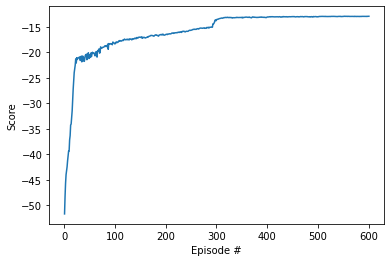

In [5]:
#Execute the cross entrophy method with default Values
#scores = cem()


#To don't ask the GPU as much reduce the pop_size, it's the amount of elemts try
scores = cem_no_net()
# 
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [3]:
# load the weights from file
# Not working know


#state = env.reset()
env = env_pybullet_kin_gen3()
env.update_parameters_to_modify(["mass","max_vel","kp","ki","damping","force_x_one","Ixx","Iyy","Izz"])
env.robot.visual_inspection = False
env.modified_parameters_df = env.create_df_from_Excel("./Parameters_train_tcp_2.xlsx")


t.sleep(0.02)
action = env.action_modified()
action = np.array(action)
print(action)
reward = env.step_tcp(action)

print("reward")
print(reward)
    

hola
../Simulation_Pybullet/models/urdf/JACO3_URDF_V11.urdf
Robot launched
hola
(7, 12)
(7, 17)
mass okey
max_vel okey
kp okey
ki okey
damping okey
force_x_one okey
Ixx okey
Iyy okey
Izz okey
[ 1.93153813e+00  1.12877937e+00  8.93141013e-01  1.22707044e+00
  4.03720400e-01  6.10483224e-01  6.85468127e-01  2.67432973e+01
  2.42329677e+01  2.84638545e+01  3.47838006e+01  3.73399319e+01
  3.28397252e+01  2.85789959e+01  1.77461660e-01  1.46501774e-01
  5.97129083e-02  2.02017925e-01  1.35557599e-01  1.49188938e-01
  9.79341382e-02  7.33530240e-05 -1.69669802e-02  4.03072907e-02
  2.65157984e-03  5.26894908e-02 -3.30160777e-04  3.11839605e-05
  9.74793060e-02  1.02717314e-01  8.18976384e-02  9.03319031e-02
  4.23498118e-02  1.10098305e-01  1.00585812e-01  1.27918737e+00
  9.70631495e-01  9.61354567e-01  9.43191786e-01  1.01199205e+00
  1.21416874e+00  9.76248817e-01  2.53045816e-03  8.22390083e-03
  8.75306937e-03  6.93540870e-03  2.30708499e-03  2.14017150e-03
  8.11559984e-04  3.84457576

In [4]:
#Convert to excel
a = env.df_avg.to_numpy()
print(a[:,5])
env.df_avg.to_excel("./Train_parameters_result_tcp_2.xlsx")

[ 4.69733641e-10 -2.18804250e-07 -1.00637420e-06 -9.41305758e-07
 -7.13956472e-07 -9.63225634e-07 -1.18773668e-06 -1.42718141e-06
 -1.72127041e-06 -2.10266939e-06 -2.60451356e-06 -3.26863571e-06
 -4.15778717e-06 -5.37883125e-06 -7.75085200e-06 -1.09275805e-05
 -1.62467475e-05 -2.61504898e-05 -5.35355761e-05  1.65574278e-08
 -3.14153072e+00 -3.14156228e+00 -3.14157258e+00 -3.14157774e+00
 -3.14158087e+00 -3.14158290e+00 -3.14158395e+00 -3.14158469e+00
 -3.14158531e+00 -3.14158585e+00 -3.14158634e+00 -3.14158677e+00
 -3.14158716e+00 -3.14158752e+00 -3.14158785e+00 -3.14158815e+00
 -3.14158843e+00 -3.14158869e+00 -3.14158893e+00 -3.14158916e+00
 -3.14158937e+00 -3.14158958e+00 -3.14158977e+00 -3.14158995e+00
 -3.14159013e+00 -3.14159029e+00 -3.14159045e+00 -3.14159061e+00
 -3.14159076e+00 -3.14159090e+00 -3.14159104e+00 -3.14159118e+00
 -3.14159131e+00 -3.14159144e+00 -3.14159157e+00 -3.14159169e+00
 -3.14159182e+00 -3.14159193e+00 -3.14159198e+00 -3.14159206e+00
 -3.14159216e+00 -3.14159

In [ ]:
env.original_parameters_df